In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
#import tensorflow_addons as tfa

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import os
import random
from PIL import Image, ImageOps
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2


2025-05-23 12:04:13.493128: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748001853.664162      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748001853.715886      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
#pip install tensorflow-addons


In [2]:
def count_images_per_class(base_path):
    class_counts = {}
    for class_name in os.listdir(base_path):
        class_folder = os.path.join(base_path, class_name)
        if os.path.isdir(class_folder):
            class_counts[class_name] = len(os.listdir(class_folder))
    return class_counts

In [3]:
train_path = "/kaggle/input/new-prep-3ds-train/conc_preprocessed_train"
aff_test_path = "/kaggle/input/3-ds-conc/Affectnet_test_data"
FER_test_path = "/kaggle/input/3-ds-conc/FER_test_data"
RAF_test_path = "/kaggle/input/3-ds-conc/RAF_test_data"

train_counts = count_images_per_class(train_path)
aff_test_counts = count_images_per_class(aff_test_path)
FER_test_counts = count_images_per_class(FER_test_path)
RAF_test_counts = count_images_per_class(RAF_test_path)

/tmp/ipykernel_35/828485367.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(train_counts.keys(), rotation=45)
/tmp/ipykernel_35/828485367.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(aff_test_counts.keys(), rotation=45)


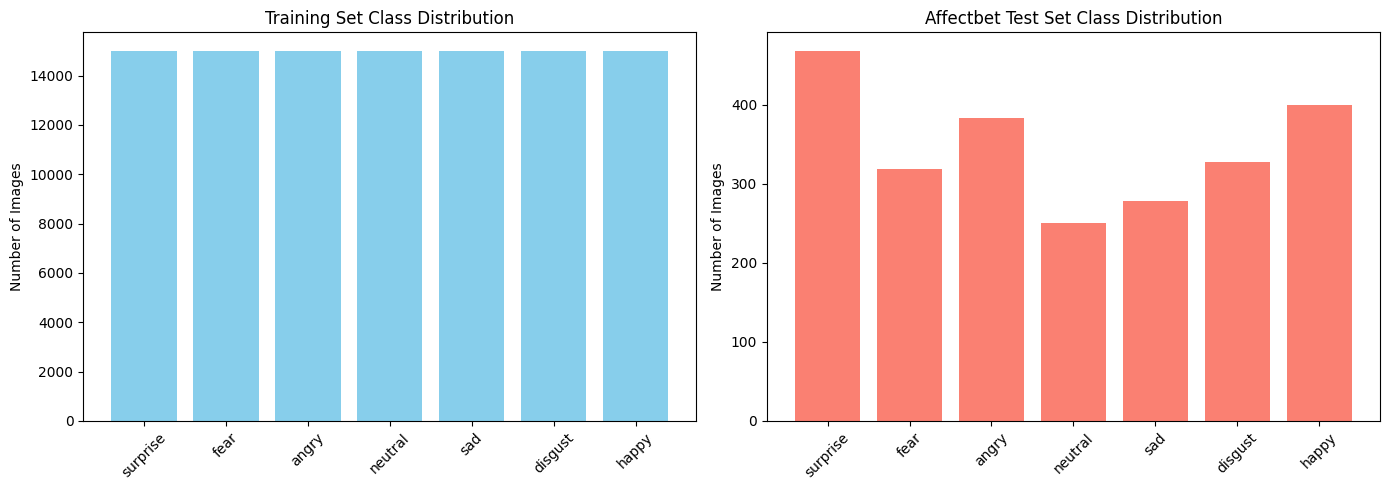

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].bar(train_counts.keys(), train_counts.values(), color='skyblue')
axs[0].set_title("Training Set Class Distribution")
axs[0].set_ylabel("Number of Images")
axs[0].set_xticklabels(train_counts.keys(), rotation=45)

axs[1].bar(aff_test_counts.keys(), aff_test_counts.values(), color='salmon')
axs[1].set_title("Affectbet Test Set Class Distribution")
axs[1].set_ylabel("Number of Images")
axs[1].set_xticklabels(aff_test_counts.keys(), rotation=45)

plt.tight_layout()
plt.show()

/tmp/ipykernel_35/2594058965.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(FER_test_counts.keys(), rotation=45)
/tmp/ipykernel_35/2594058965.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(RAF_test_counts.keys(), rotation=45)


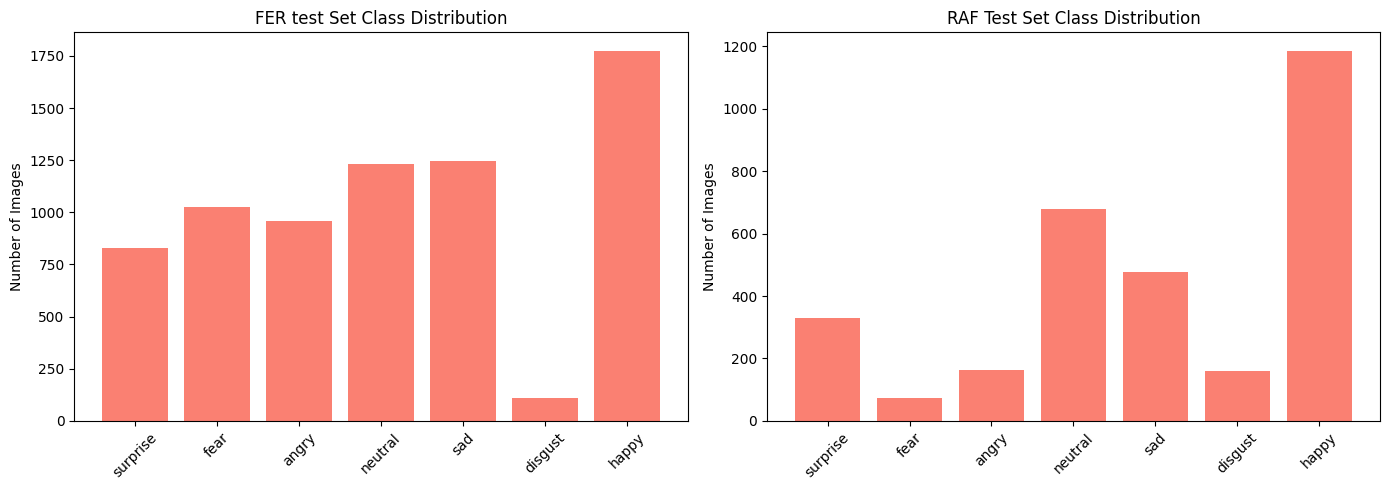

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].bar(FER_test_counts.keys(), FER_test_counts.values(), color='salmon')
axs[0].set_title("FER test Set Class Distribution")
axs[0].set_ylabel("Number of Images")
axs[0].set_xticklabels(FER_test_counts.keys(), rotation=45)

axs[1].bar(RAF_test_counts.keys(), RAF_test_counts.values(), color='salmon')
axs[1].set_title("RAF Test Set Class Distribution")
axs[1].set_ylabel("Number of Images")
axs[1].set_xticklabels(RAF_test_counts.keys(), rotation=45)

plt.tight_layout()
plt.show()

In [6]:

img_size = (224, 224)             
batch_size = 32
seed = 123

# Load training dataset (80%)
train_ds = image_dataset_from_directory(
    train_path,
    labels='inferred',
    shuffle=True,
    label_mode='categorical',
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

# Load validation dataset (20%)
val_ds = image_dataset_from_directory(
    train_path,
    labels='inferred',
    shuffle=True,
    label_mode='categorical',
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

FER_test_ds = image_dataset_from_directory(
    FER_test_path,
    labels='inferred',    
    shuffle=True,
    label_mode='categorical',
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

RAF_test_ds = image_dataset_from_directory(
    RAF_test_path,
    labels='inferred',
    label_mode='categorical',
    shuffle=True,
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

Affec_test_ds = image_dataset_from_directory(
    aff_test_path,
    shuffle=True,
    labels='inferred',
    label_mode='categorical',
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)
'''def augment_and_preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image, label'''

'''def augment_image(image, label):
    """Apply random augmentation using TensorFlow ops."""
    
    # Random horizontal flip
    image = tf.image.random_flip_left_right(image)

    # Random rotation
    angles = tf.random.uniform([], minval=-0.52, maxval=0.52)  # -30 to +30 degrees in radians
    image = tf.image.rotate(image, angles)

    # Random crop (slightly)
    crop_size = tf.cast(tf.shape(image)[:2] * 0.9, tf.int32)
    image = tf.image.random_crop(image, size=tf.concat([crop_size, [3]], axis=0))
    image = tf.image.resize(image, tf.shape(image)[:2])  # Resize to original size

    return image, label
'''
class_names = train_ds.class_names

def preprocess(image, label):
    image = preprocess_input(image)
    return image, label
    

train_ds = train_ds.map(preprocess)
val_ds = val_ds.map(preprocess)
Affec_test_ds = Affec_test_ds.map(preprocess)
RAF_test_ds = RAF_test_ds.map(preprocess)
FER_test_ds = FER_test_ds.map(preprocess)


# Optional: Improve performance with prefetching
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.prefetch(buffer_size=AUTOTUNE)


Found 105000 files belonging to 7 classes.
Using 84000 files for training.


I0000 00:00:1748002021.755467      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 105000 files belonging to 7 classes.
Using 21000 files for validation.
Found 7178 files belonging to 7 classes.
Found 3068 files belonging to 7 classes.
Found 2423 files belonging to 7 classes.


In [7]:
class_names

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [21]:
base_model_v2 = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model_v2.trainable = False  # Freeze the base model

In [22]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model_v2(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(7, activation='softmax')(x)

modelv2 = tf.keras.Model(inputs, outputs)

modelv2.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

modelv2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,439,367 (9.31 MB)

 Trainable params: 181,383 (708.53 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [23]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)




early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)




In [24]:
history=modelv2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
    ,callbacks=[lr_schedule,early_stop]
)

Epoch 1/10
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 78s 26ms/step - accuracy: 0.1594 - loss: 2.1090 - val_accuracy: 0.2793 - val_loss: 1.8769 - learning_rate: 1.0000e-04
Epoch 2/10
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 63s 24ms/step - accuracy: 0.2263 - loss: 1.8806 - val_accuracy: 0.3180 - val_loss: 1.7935 - learning_rate: 1.0000e-04
Epoch 3/10
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 63s 24ms/step - accuracy: 0.2690 - loss: 1.8235 - val_accuracy: 0.3395 - val_loss: 1.7534 - learning_rate: 1.0000e-04
Epoch 4/10
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 63s 24ms/step - accuracy: 0.2877 - loss: 1.7893 - val_accuracy: 0.3600 - val_loss: 1.7153 - learning_rate: 1.0000e-04
Epoch 5/10
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 63s 24ms/step - accuracy: 0.3068 - loss: 1.7598 - val_accuracy: 0.3741 - val_loss: 1.6922 - learning_rate: 1.0000e-04
Epoch 6/10
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 63s 24ms/step - accuracy: 0.3171 - loss: 1.7359 - val_accuracy: 0.3817 - val_loss: 1.6709 - learning_rate: 1.0000e-04
Epoch 7/10
2625/2625 ━━━━━━━━━━━━━━━━━━━

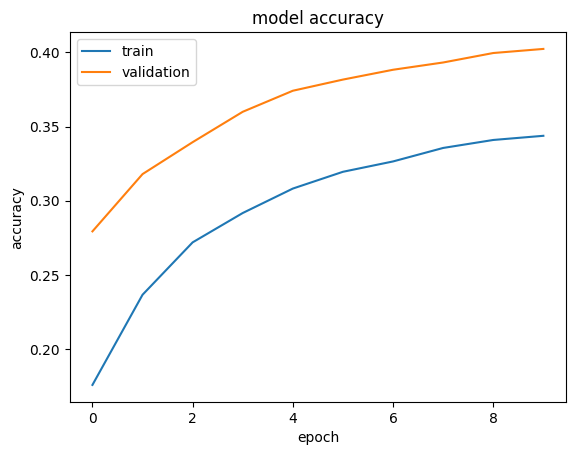

In [25]:
def plot_hist(history):
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()
    
plot_hist(history)

In [26]:
# Unfreeze the base model
base_model_v2.trainable = True

# Optional: Fine-tune only the last few layers
fine_tune_at = 50  # Unfreeze from this layer onwards
for layer in base_model_v2.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile with a lower learning rate
modelv2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training
history=modelv2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
    ,callbacks=[lr_schedule,early_stop]
)


Epoch 1/4
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 158s 46ms/step - accuracy: 0.4108 - loss: 1.5282 - val_accuracy: 0.5469 - val_loss: 1.2210 - learning_rate: 1.0000e-04
Epoch 2/4
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 116s 44ms/step - accuracy: 0.5688 - loss: 1.1789 - val_accuracy: 0.6036 - val_loss: 1.0477 - learning_rate: 1.0000e-04
Epoch 3/4
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 116s 44ms/step - accuracy: 0.6347 - loss: 1.0214 - val_accuracy: 0.6179 - val_loss: 1.0490 - learning_rate: 1.0000e-04
Epoch 4/4
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 116s 44ms/step - accuracy: 0.6870 - loss: 0.8895 - val_accuracy: 0.6487 - val_loss: 0.9825 - learning_rate: 1.0000e-04


In [27]:
# Unfreeze the base model
base_model_v2.trainable = True

# Optional: Fine-tune only the last few layers
fine_tune_at = 75  # Unfreeze from this layer onwards
for layer in base_model_v2.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile with a lower learning rate
modelv2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training
history=modelv2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
    ,callbacks=[lr_schedule,early_stop]
)


Epoch 1/3
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 143s 42ms/step - accuracy: 0.7484 - loss: 0.7277 - val_accuracy: 0.6850 - val_loss: 0.9054 - learning_rate: 1.0000e-05
Epoch 2/3
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 106s 40ms/step - accuracy: 0.7745 - loss: 0.6480 - val_accuracy: 0.6860 - val_loss: 0.9295 - learning_rate: 1.0000e-05
Epoch 3/3
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 106s 41ms/step - accuracy: 0.7940 - loss: 0.5954 - val_accuracy: 0.6841 - val_loss: 0.9603 - learning_rate: 1.0000e-05


In [28]:
# Unfreeze the base model
base_model_v2.trainable = True

# Optional: Fine-tune only the last few layers
fine_tune_at = 100  # Unfreeze from this layer onwards
for layer in base_model_v2.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile with a lower learning rate
modelv2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training
history=modelv2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
    ,callbacks=[lr_schedule,early_stop]
)


Epoch 1/3
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 122s 37ms/step - accuracy: 0.7758 - loss: 0.6496 - val_accuracy: 0.6860 - val_loss: 0.9230 - learning_rate: 1.0000e-05
Epoch 2/3
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 92s 35ms/step - accuracy: 0.7916 - loss: 0.6079 - val_accuracy: 0.6846 - val_loss: 0.9480 - learning_rate: 1.0000e-05
Epoch 3/3
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 92s 35ms/step - accuracy: 0.8060 - loss: 0.5666 - val_accuracy: 0.6830 - val_loss: 0.9770 - learning_rate: 1.0000e-05


In [29]:
modelv2.evaluate(train_ds)

2625/2625 ━━━━━━━━━━━━━━━━━━━━ 50s 19ms/step - accuracy: 0.8264 - loss: 0.4839


[0.436276376247406, 0.8465476036071777]

In [30]:
modelv2.evaluate(val_ds,)


657/657 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.6866 - loss: 0.9127


[0.9230429530143738, 0.6860476136207581]

In [31]:
modelv2.evaluate(FER_test_ds)


225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6547 - loss: 0.9946


[0.9852890968322754, 0.6635553240776062]

In [32]:
modelv2.evaluate(RAF_test_ds)


96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.8154 - loss: 0.6363


[0.6118477582931519, 0.8177965879440308]

In [33]:
modelv2.evaluate(Affec_test_ds)


76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.7138 - loss: 0.9273


[0.9188850522041321, 0.7189434766769409]

###### modelv2.save('mobilenet_V2modelon3ds.h5')
